In [2]:
!pip install nltk

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# t-SNE and Bokeh vis
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [5]:
LTC_BINARY = '../data/ltc_matrices/ltc_matrix_binary_mm4.tsv'

ltc_patients = pd.read_csv(LTC_BINARY, sep = '\t')

ltc_patients.head(5)


patient_id  dermatitis  erectile_dysfunction  OA  pri_skin  skin_ulcer  \
0     1000059           1                     1   1         1           1   
1     1000062           0                     0   0         0           0   
2     1000077           0                     0   0         1           0   
3     1000124           0                     0   1         0           0   
4     1000146           0                     0   1         1           0   

   female_genital_prolapse  fracture_hip  obesity  spondylosis  ...  \
0                        0             0        0            0  ...   
1                        1             1        1            1  ...   
2                        0             0        0            0  ...   
3                        0             0        0            0  ...   
4                        0             0        0            0  ...   

   cerebral_palsy  pri_mesothelioma  pri_brain  thala  sick_sinus  ADHD  \
0               0                 0          0      0           0     0   
1               0                 0          0      0           0     0   
2               0                 0          0      0           0     0   
3               0                 0          0      0           0     0   
4               0                 0          0      0           0     0   

   juv_arth  downs  entero_arthro  SARS_CoV2  
0         0      0              0          0  
1         0      0              0          0  
2         0      0              0          0  
3         0      0              0          0  
4         0      0              0          0  

[5 rows x 204 columns]

In [6]:
list_of_patients = []

patients = ltc_patients['patient_id'].unique()
ltcs = ltc_patients.drop('patient_id', axis = 1)
index = 0

# Iterate through patients
for patient in patients:
    
    # Start with empty list of LTCs for each patient
    patient_ltcs = []
    
    # Iterate through each LTC for patient
    for ltc in ltcs:
        
        # Check if patient has LTC
        if ltc_patients.at[index, ltc] == 1:
            
            # If LTC present, add to list of patient LTCs
            patient_ltcs.append(ltc)   
    
    # Add list of patient LTCs to list of patients        
    list_of_patients.append(patient_ltcs)
    
    # Increment index by 1
    index+=1

In [7]:
pp.pprint(list_of_patients[0:3])
pp.pprint("Documents in corpus: {l}".format(l=len(list_of_patients)))

[   ['dermatitis', 'erectile_dysfunction', 'OA', 'pri_skin', 'skin_ulcer'],
    [   'female_genital_prolapse',
        'fracture_hip',
        'obesity',
        'spondylosis',
        'type_2_diabetes',
        'unspecified_rare_diabetes',
        'urine_incont'],
    [   'pri_skin',
        'allergic_rhinitis',
        'atrial_fibrilation',
        'cholelithiasis',
        'CKD',
        'cystic_renal',
        'enthesopathy',
        'epilepsy',
        'ESRD',
        'gout',
        'hearing_loss',
        'hypertension',
        'pri_other',
        'thyroid',
        'venous_thromb']]
'Documents in corpus: 143168'


In [8]:
id2word = corpora.Dictionary(list_of_patients)

corpus = []
for text in list_of_patients:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [11]:
print(corpus[202][0:10])
print(id2word[202])

[(14, 1), (18, 1), (22, 1), (61, 1), (144, 1)]
SARS_CoV2


In [13]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           workers=3,
                                           random_state=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha="symmetric")

# Note: num_topics attempted: 20, 15, 10, 5, 6, 4

In [14]:
pp.pprint(lda_model.print_topics())

[   (   0,
        '0.083*"oth_anaemia" + 0.066*"osteoporosis" + '
        '0.061*"iron_deficiency_anaemia" + 0.050*"depression" + '
        '0.036*"thyroid" + 0.033*"OA" + 0.032*"hypertension" + '
        '0.027*"dermatitis" + 0.027*"enthesopathy" + 0.024*"anxiety_phobia"'),
    (   1,
        '0.073*"depression" + 0.061*"enthesopathy" + 0.060*"dermatitis" + '
        '0.058*"sinusitis" + 0.051*"anxiety_phobia" + '
        '0.051*"allergic_rhinitis" + 0.037*"PTSD" + 0.037*"migraine" + '
        '0.036*"OA" + 0.035*"irritable_bowel_syndrome"'),
    (   2,
        '0.102*"type_2_diabetes" + 0.087*"oesoph_ulc" + 0.083*"GORD" + '
        '0.078*"hypertension" + 0.063*"unspecified_rare_diabetes" + '
        '0.048*"obesity" + 0.045*"diab_eye" + 0.042*"gastritis_duodenitis" + '
        '0.033*"ulcer_peptic" + 0.032*"depression"'),
    (   3,
        '0.082*"hypertension" + 0.060*"enthesopathy" + 0.052*"dermatitis" + '
        '0.051*"OA" + 0.040*"hearing_loss" + 0.039*"erectile_dysfunction"

In [15]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

G:\anacondapy3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.180192  0.091666       1        1  40.544483
3      0.047365  0.190329       2        1  28.232116
2      0.278161 -0.055962       3        1  16.641188
0     -0.145335 -0.226033       4        1  14.582213, topic_info=                         Term          Freq         Total Category  logprob  \
9             type_2_diabetes  18712.000000  18712.000000  Default  30.0000   
74                 oesoph_ulc  15902.000000  15902.000000  Default  29.0000   
72                       GORD  25243.000000  25243.000000  Default  28.0000   
96                oth_anaemia  13400.000000  13400.000000  Default  27.0000   
10  unspecified_rare_diabetes  11578.000000  11578.000000  Default  26.0000   
..                        ...           ...           ...      ...      ...   
18               enthesopathy   4423.857342  56214.283586   Topic4  -3.5948   
21               hearing_loss   2123.716402  25662.177707   Topic4  -4.3286   
42               diverticular   1699.422495  13250.116663   Topic4  -4.5515   
36       gastritis_duodenitis   1605.406829  17996.135573   Topic4  -4.6084   
3                    pri_skin   1489.772087   9659.920903   Topic4  -4.6832   

    loglift  
9   30.0000  
74  29.0000  
72  28.0000  
96  27.0000  
10  26.0000  
..      ...  
18  -0.6168  
21  -0.5665  
42  -0.1284  
36  -0.4914  
3    0.0560  

[235 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
128       4  0.999102                BAD
33        2  0.999961                BPH
30        2  0.999742                CCD
56        2  0.740053                CHD
56        3  0.259950                CHD
...     ...       ...                ...
25        2  0.467456      venous_thromb
25        4  0.532416      venous_thromb
50        3  0.318282  vitb12_deficiency
50        4  0.681745  vitb12_deficiency
135       4  0.999094           vitiligo

[265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [18]:
def find_dominant_topics(ldamodel=None, corpus=corpus, texts=list_of_patients):
    
    dom_topics = pd.DataFrame()

    # Get main topic for each patient
    for i, row_list in enumerate(ldamodel[corpus]):
        
        if ldamodel.per_word_topics:
            row = row_list[0]
        else:
            row = row_list
        #print(row)
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each patient
        for j, (topic_num, prop_topic) in enumerate(row):
            
            # If dominant topic
            if j == 0:
                
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                dom_topics = dom_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    dom_topics.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original patient record to the end of the output
    contents = pd.Series(texts)
    dom_topics = pd.concat([dom_topics, contents], axis=1)
    
    return dom_topics


temp = find_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=list_of_patients)

# Format
dominant_patient_topics = temp.reset_index()
dominant_patient_topics.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
dominant_patient_topics.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.8712   
1            1             2.0              0.4293   
2            2             3.0              0.7412   
3            3             1.0              0.9107   
4            4             3.0              0.8460   
5            5             1.0              0.8352   
6            6             2.0              0.6064   
7            7             2.0              0.5422   
8            8             2.0              0.4854   
9            9             1.0              0.8718   

                                            Keywords  \
0  hypertension, enthesopathy, dermatitis, OA, he...   
1  type_2_diabetes, oesoph_ulc, GORD, hypertensio...   
2  hypertension, enthesopathy, dermatitis, OA, he...   
3  depression, enthesopathy, dermatitis, sinusiti...   
4  hypertension, enthesopathy, dermatitis, OA, he...   
5  depression, enthesopathy, dermatitis, sinusiti...   
6  type_2_diabetes, oesoph_ulc, GORD, hypertensio...   
7  type_2_diabetes, oesoph_ulc, GORD, hypertensio...   
8  type_2_diabetes, oesoph_ulc, GORD, hypertensio...   
9  depression, enthesopathy, dermatitis, sinusiti...   

                                                Text  
0  [dermatitis, erectile_dysfunction, OA, pri_ski...  
1  [female_genital_prolapse, fracture_hip, obesit...  
2  [pri_skin, allergic_rhinitis, atrial_fibrilati...  
3  [OA, enthesopathy, hypertension, thyroid, cons...  
4                  [OA, pri_skin, enthesopathy, CCD]  
5  [allergic_rhinitis, enthesopathy, hypertension...  
6  [erectile_dysfunction, type_2_diabetes, allerg...  
7  [erectile_dysfunction, pri_skin, type_2_diabet...  
8  [dermatitis, type_2_diabetes, enthesopathy, hy...  
9  [OA, allergic_rhinitis, menorrhagia, asthma, f...

In [19]:
dominant_patient_topics.describe()

Document_No  Dominant_Topic  Topic_Perc_Contrib
count  143168.000000   143168.000000       143168.000000
mean    71583.500000        1.651256            0.685976
std     41329.186007        1.023935            0.168343
min         0.000000        0.000000            0.250000
25%     35791.750000        1.000000            0.540400
50%     71583.500000        1.000000            0.671900
75%    107375.250000        3.000000            0.847700
max    143167.000000        3.000000            0.967500

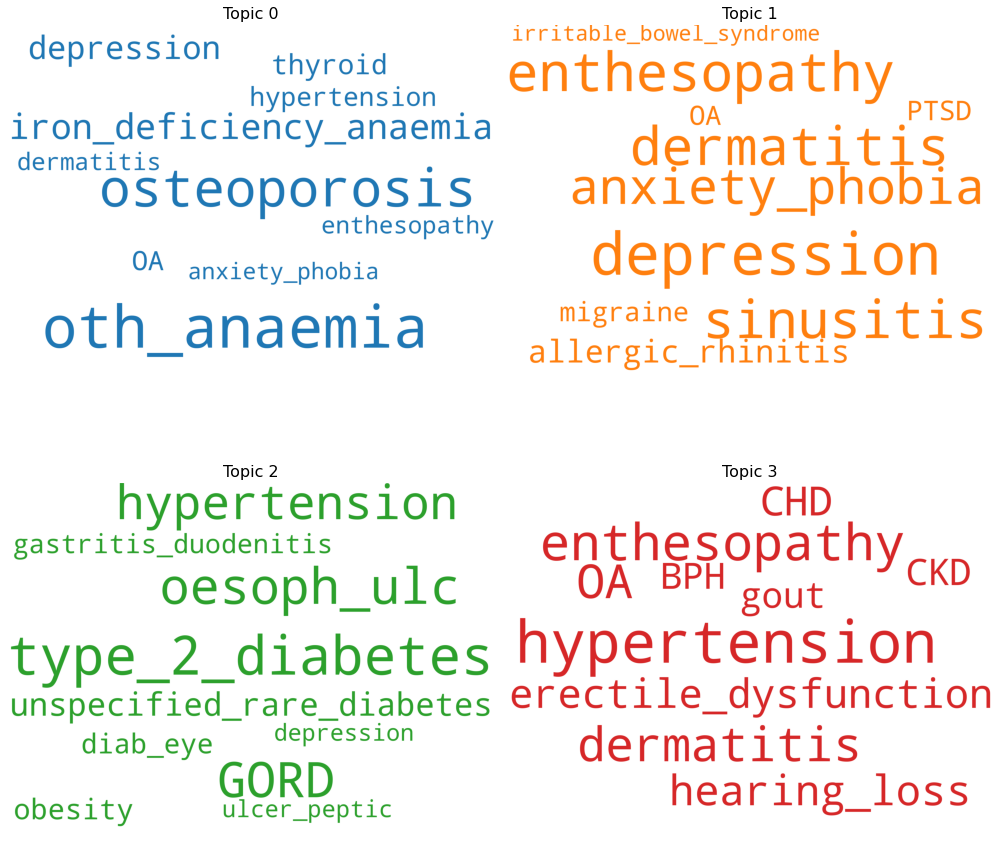

<Figure size 432x288 with 0 Axes>

In [33]:
# Wordcloud of Top N LTCs for each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(14,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
plt.savefig("../images/4 Topics WordCloud.png", dpi=100)

In [24]:
dominant_topic_weights = []

# Get topic weights
for i, row_list in enumerate(lda_model[corpus]):
    
    row_list.sort(reverse=True, key=lambda x: (x[1]))
    dominant_topic_weights.append(row_list[0])
    
    if i < 3:
        pp.pprint(i)
        pp.pprint(row_list)
        
for x in range(3):
        pp.pprint("Dominant Topics with Weights: {n}".format(n = dominant_topic_weights[x]))
        
# Array of topic weights    
arr = pd.DataFrame(dominant_topic_weights).fillna(0).values

# for x in range(3):
#         pp.pprint("Original Array of Topic Weights: {n}".format(n = arr[x]))


# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=300, random_state=0, angle=.19, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

0
[(3, 0.8712263), (1, 0.04354309), (0, 0.04281634), (2, 0.042414248)]
1
[(2, 0.42934638), (1, 0.329831), (0, 0.20885731), (3, 0.031965323)]
2
[(3, 0.74124986), (0, 0.14740859), (2, 0.09478137), (1, 0.016560188)]
'Dominant Topics with Weights: (3, 0.8712263)'
'Dominant Topics with Weights: (2, 0.42934638)'
'Dominant Topics with Weights: (3, 0.74124986)'


In [25]:
output_notebook()
n_topics = 4

topic_num = [int(x[0]) for x in arr]
# topic_num = [int(a) for a in topic_num]
for x in range(3):
    pp.pprint("Dominant topic in each doc: {n}".format(n = topic_num[x]))


mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

'Dominant topic in each doc: 3'
'Dominant topic in each doc: 2'
'Dominant topic in each doc: 3'


In [31]:
for i in range (4):
    pp.pprint("Count for Dominant topic {i}: {n}".format(i=i, n = len(dominant_patient_topics[dominant_patient_topics['Dominant_Topic']==i])))

'Count for Dominant topic 0: 13877'
'Count for Dominant topic 1: 67091'
'Count for Dominant topic 2: 17284'
'Count for Dominant topic 3: 44916'


In [23]:
def Func(e):
    return e[1]

test = []
test_dom_topic = []

for i, row_list in enumerate(lda_model[corpus]):
    if i < 5:
        row_list.sort(reverse=True, key = lambda x: (x[1]))
        test.append(row_list[0])
    else:
        break
test_dom_topic = [x[0] for x in test]    
print(test)
print(test_dom_topic)

[(3, 0.87122124), (2, 0.42937404), (3, 0.741195), (1, 0.91067934), (3, 0.84595925)]
[3, 2, 3, 1, 3]
